In [ ]:
#Allocating GPU for the models resource

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE = 224
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3000 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(8, 224, 224, 3)
[1 0 0 1 1 0 0 1]


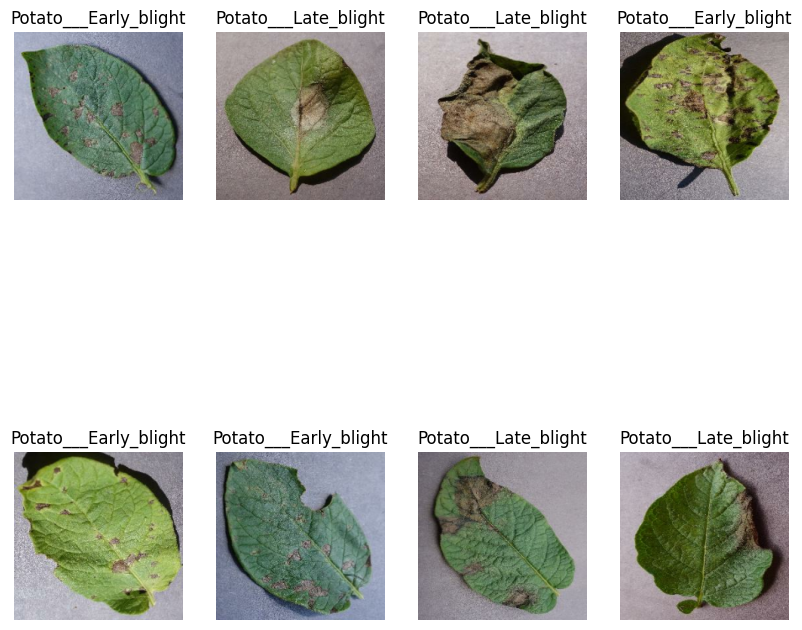

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

375

In [ ]:
train_size = 0.8
len(dataset)*train_size

300.0

In [ ]:
train_ds = dataset.take(300)
len(train_ds)

300

In [ ]:
test_ds = dataset.skip(300)
len(test_ds)

75

In [ ]:
val_size=0.1
len(dataset)*val_size

37.5

In [ ]:
val_ds = test_ds.take(37)
len(val_ds)

37

In [ ]:
test_ds = test_ds.skip(37)
len(test_ds)

38

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print("Training Dataset Size: ", len(train_ds))
print("Validation Dataset Size: ", len(val_ds))
print("Test Dataset Size: ", len(test_ds))

Training Dataset Size:  300
Validation Dataset Size:  37
Test Dataset Size:  38


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

In [ ]:
from tensorflow.keras.applications import DenseNet121

IMAGE_SIZE = 224
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 50
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = True

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,

    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                      

In [ ]:
model.compile(
    optimizer='rmsprop',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
300/300 [==============================] - 135s 318ms/step - loss: 0.6532 - accuracy: 0.7962 - val_loss: 10.7223 - val_accuracy: 0.3784
Epoch 2/50
300/300 [==============================] - 92s 306ms/step - loss: 0.2878 - accuracy: 0.9150 - val_loss: 6.3392 - val_accuracy: 0.6419
Epoch 3/50
300/300 [==============================] - 92s 306ms/step - loss: 0.2090 - accuracy: 0.9358 - val_loss: 6.5684 - val_accuracy: 0.5439
Epoch 4/50
300/300 [==============================] - 92s 306ms/step - loss: 0.1882 - accuracy: 0.9479 - val_loss: 0.8932 - val_accuracy: 0.7331
Epoch 5/50
300/300 [==============================] - 92s 307ms/step - loss: 0.1782 - accuracy: 0.9550 - val_loss: 0.2761 - val_accuracy: 0.9324
Epoch 6/50
300/300 [==============================] - 92s 306ms/step - loss: 0.1387 - accuracy: 0.9642 - val_loss: 6.2170 - val_accuracy: 0.6892
Epoch 7/50
300/300 [==============================] - 92s 306ms/step - loss: 0.1464 - accuracy: 0.9629 - val_loss: 0.0209 - val_

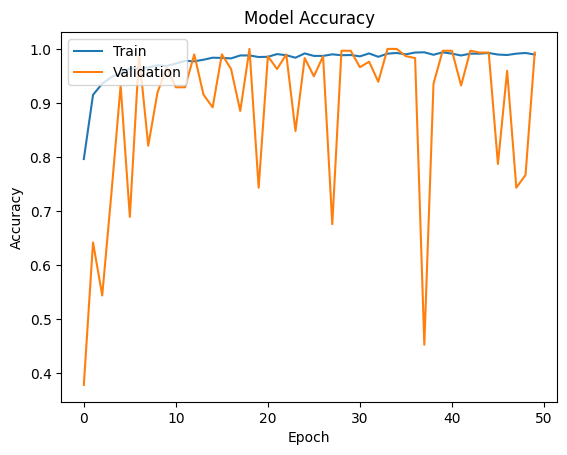

In [ ]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
except NameError:
    print("Variable 'history' is not defined. Please make sure you have executed the cell that defines this variable.")

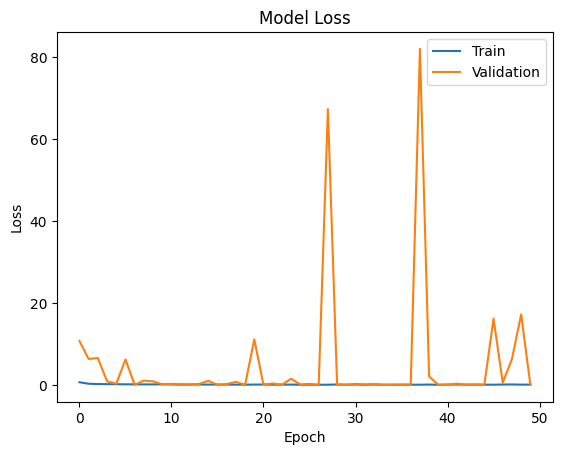

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

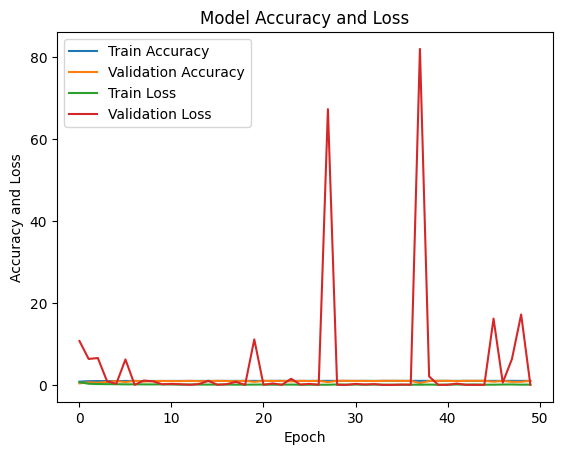

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate(test_ds)

history.params

history.history['accuracy']

38/38 [==============================] - 38s 78ms/step - loss: 0.0264 - accuracy: 0.9934


[0.7962499856948853,
 0.9150000214576721,
 0.9358333349227905,
 0.9479166865348816,
 0.9549999833106995,
 0.9641666412353516,
 0.9629166722297668,
 0.965833306312561,
 0.9695833325386047,
 0.9683333039283752,
 0.9729166626930237,
 0.9779166579246521,
 0.9770833253860474,
 0.9800000190734863,
 0.9837499856948853,
 0.9833333492279053,
 0.9825000166893005,
 0.9879166483879089,
 0.9879166483879089,
 0.9850000143051147,
 0.9854166507720947,
 0.9904166460037231,
 0.9883333444595337,
 0.9837499856948853,
 0.9916666746139526,
 0.9870833158493042,
 0.9870833158493042,
 0.9900000095367432,
 0.9883333444595337,
 0.9887499809265137,
 0.9862499833106995,
 0.9916666746139526,
 0.9854166507720947,
 0.9912499785423279,
 0.9925000071525574,
 0.9900000095367432,
 0.9933333396911621,
 0.9937499761581421,
 0.9891666769981384,
 0.9937499761581421,
 0.9912499785423279,
 0.9879166483879089,
 0.9912499785423279,
 0.9912499785423279,
 0.9925000071525574,
 0.9895833134651184,
 0.9887499809265137,
 0.99124997854

In [ ]:
history.history['val_accuracy']

[0.37837839126586914,
 0.6418918967247009,
 0.5439189076423645,
 0.7331081032752991,
 0.9324324131011963,
 0.6891891956329346,
 0.9898648858070374,
 0.8209459185600281,
 0.9189189076423645,
 0.9662162065505981,
 0.9290540814399719,
 0.9290540814399719,
 0.9898648858070374,
 0.9155405163764954,
 0.8918918967247009,
 0.9898648858070374,
 0.962837815284729,
 0.8851351141929626,
 1.0,
 0.7432432174682617,
 0.9864864945411682,
 0.962837815284729,
 0.9898648858070374,
 0.8479729890823364,
 0.9831081032752991,
 0.9493243098258972,
 0.9864864945411682,
 0.6756756901741028,
 0.9966216087341309,
 0.9966216087341309,
 0.9662162065505981,
 0.9763513803482056,
 0.9391891956329346,
 1.0,
 1.0,
 0.9864864945411682,
 0.9831081032752991,
 0.45270270109176636,
 0.9358108043670654,
 0.9966216087341309,
 0.9966216087341309,
 0.9324324131011963,
 0.9966216087341309,
 0.9932432174682617,
 0.9932432174682617,
 0.787162184715271,
 0.9594594836235046,
 0.7432432174682617,
 0.7668918967247009,
 0.99324321746826

In [ ]:
history.history['loss']

[0.6532452702522278,
 0.2878178060054779,
 0.20902346074581146,
 0.1881810575723648,
 0.17819350957870483,
 0.13874433934688568,
 0.14638498425483704,
 0.12744729220867157,
 0.12348457425832748,
 0.14441485702991486,
 0.11409369111061096,
 0.07928729057312012,
 0.11185446381568909,
 0.09156055748462677,
 0.08265644311904907,
 0.07977979630231857,
 0.09013108909130096,
 0.06428923457860947,
 0.06380221992731094,
 0.0794576108455658,
 0.09632400423288345,
 0.060718804597854614,
 0.07885301113128662,
 0.08059798926115036,
 0.05136554688215256,
 0.05760981887578964,
 0.05261119455099106,
 0.04369067773222923,
 0.11234909296035767,
 0.066694475710392,
 0.09402437508106232,
 0.049193792045116425,
 0.0975872203707695,
 0.05940430983901024,
 0.06290704756975174,
 0.04243971407413483,
 0.05964793637394905,
 0.053509362041950226,
 0.08174426108598709,
 0.04054458811879158,
 0.07710755616426468,
 0.10248126834630966,
 0.07522822916507721,
 0.09835194796323776,
 0.06078183650970459,
 0.05841536074

In [ ]:
history.history['val_loss']

[10.722341537475586,
 6.339239120483398,
 6.568365097045898,
 0.8932362198829651,
 0.2760506570339203,
 6.217005729675293,
 0.020894117653369904,
 1.0587308406829834,
 0.8752866983413696,
 0.14657898247241974,
 0.24707159399986267,
 0.15867352485656738,
 0.026766402646899223,
 0.22169290482997894,
 1.002383828163147,
 0.03806473687291145,
 0.18224743008613586,
 0.7578074336051941,
 0.0030415814835578203,
 11.118094444274902,
 0.024932049214839935,
 0.3624846935272217,
 0.024991871789097786,
 1.5033761262893677,
 0.08374898135662079,
 0.25044527649879456,
 0.03536118566989899,
 67.33792114257812,
 0.0288782250136137,
 0.011218731291592121,
 0.25197505950927734,
 0.08929236233234406,
 0.19661551713943481,
 0.0019808472134172916,
 2.2122158043202944e-05,
 0.08770132809877396,
 0.040918756276369095,
 82.03768920898438,
 2.0715503692626953,
 0.012284193187952042,
 0.026521185413002968,
 0.31510069966316223,
 0.0249017346650362,
 0.012407704256474972,
 0.010853234678506851,
 16.1955261230468

In [ ]:
print("Accuracy: ", scores[1])
print("Loss: ", scores[0])

Accuracy:  0.9934210777282715
Loss:  0.02644476853311062


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

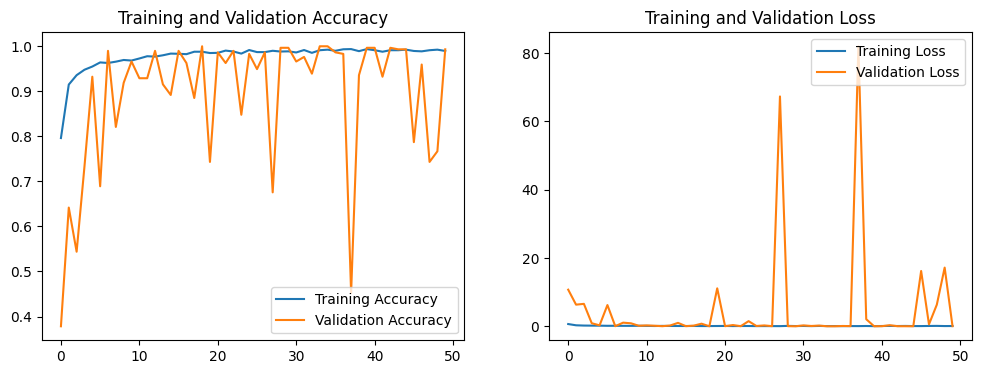

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict
First image actual label: Potato___Early_blight
1/1 [==============================] - 3s 3s/step
[9.9997163e-01 2.8337226e-05 3.2006434e-29]
Max Value: 0
Predicted Label: Potato___Early_blight


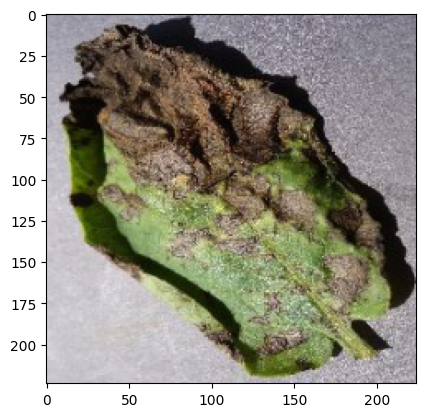

In [ ]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0]
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print(batch_prediction[0])
    print("Max Value:", np.argmax(batch_prediction[0]))
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 51ms/step


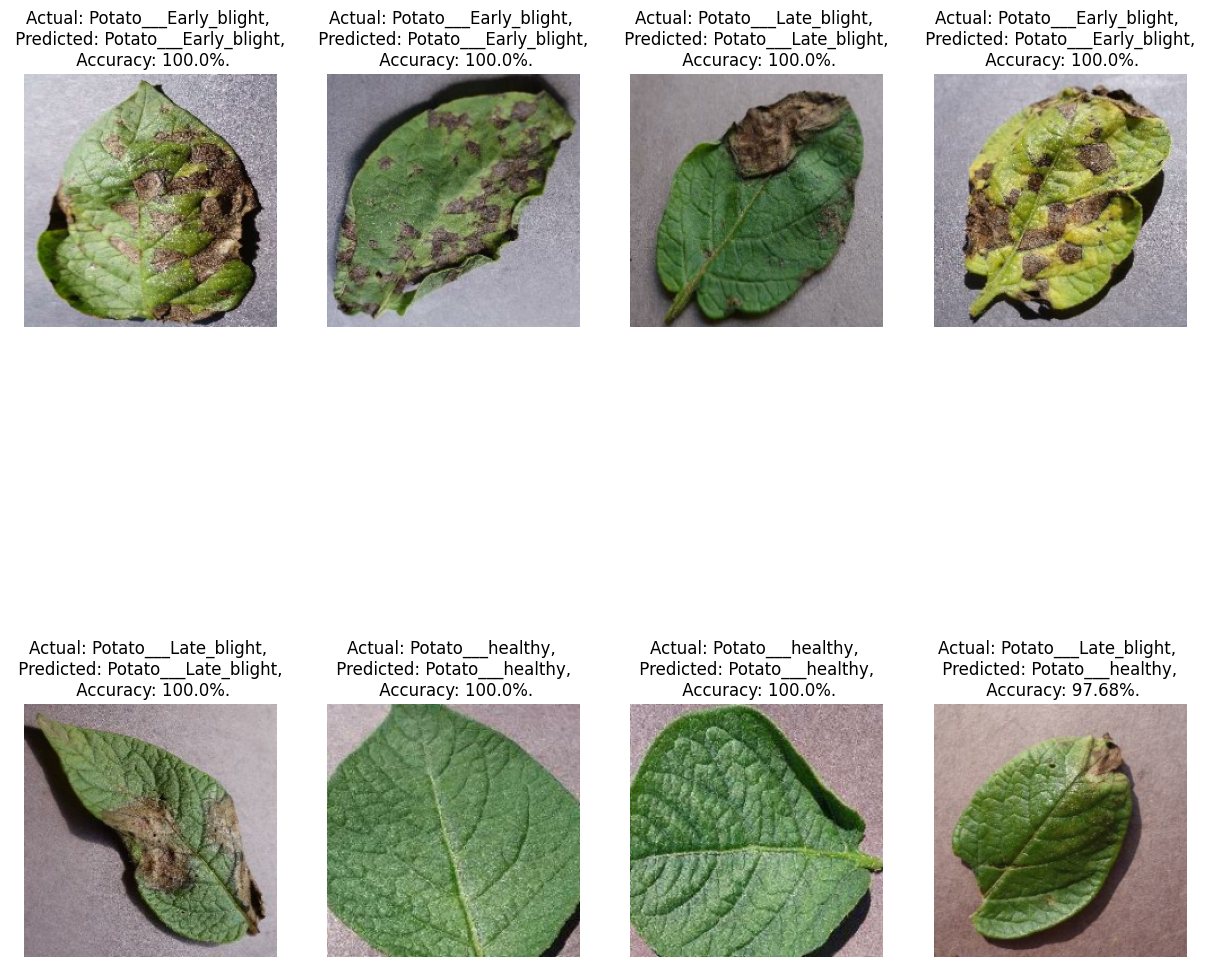

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Accuracy: {confidence}%.")  # Setting the title with actual class, predicted class, and confidence
        plt.axis("off")

In [ ]:
print("Accuracy: ", scores[1] * 100)

Accuracy:  99.34210777282715


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

f1 = f1_score(y_true, y_pred, average='weighted') * 100
precision = precision_score(y_true, y_pred, average='weighted') * 100
recall = recall_score(y_true, y_pred, average='weighted') * 100

print("F1 Score: ", f1)
print("Precision Score: ", precision)
print("Recall Score: ", recall)

38/38 [==============================] - 6s 73ms/step
F1 Score:  35.511119851258584
Precision Score:  35.50062550263604
Recall Score:  35.526315789473685


38/38 [==============================] - 3s 69ms/step


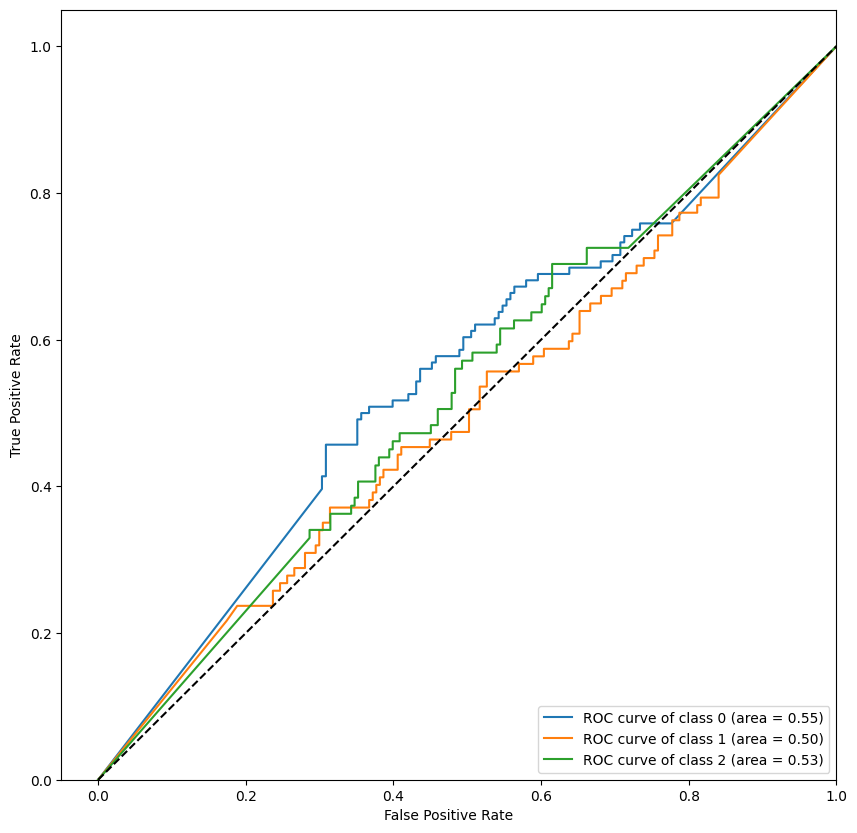

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test = label_binarize(y_true, classes=[0, 1, 2])
y_pred = model.predict(test_ds)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve of class {i} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

38/38 [==============================] - 3s 70ms/step


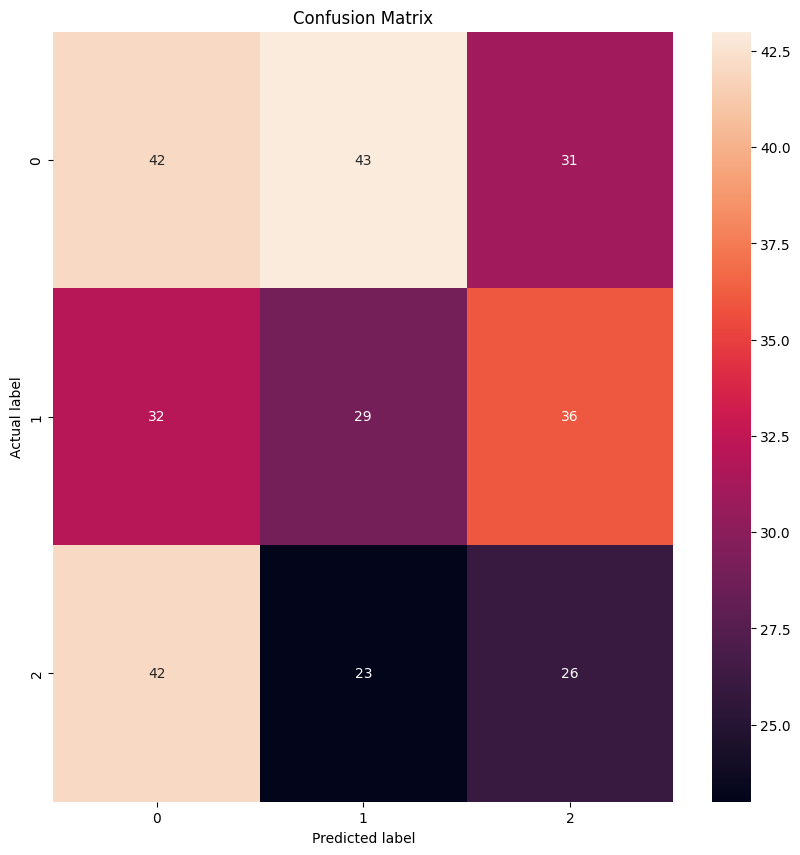

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Clear the TensorFlow session
tf.keras.backend.clear_session()